# Measuring Descent performance

This notebook demonstrates how the performance of MSTDescent is measured in the recall benchmark.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from multi_mst import KMST, KMSTDescentLogRecall

In [3]:
df = pd.read_csv('data/horse/horse.csv')

Compute global recall and precision. We expect there to be more nearest
neighbour edges than kMST edges, so this metric is not very sensitive to the
performance of the descent stage. It does show that the end-result can be usable
for visualisation.

In [10]:
mst1 = KMST(num_neighbors=5).fit(df)
mst2 = KMSTDescentLogRecall(num_neighbors=5).fit(df)
trace = mst2.trace_

m1 = mst1.graph_.copy()
m2 = mst2.graph_.copy()

m1.data[:] = 1
m2.data[:] = 1

true_positive = m1.multiply(m2).nnz
print(f'Recall: {true_positive / m1.nnz:.3f}')
print(f'Precision: {true_positive / m2.nnz:.3f}')

Recall: 0.999
Precision: 0.999


Compute global distance ratio, i.e., how much more distance is captured by
descent-k-MST vs exact k-MST. Similar, to the global recall, this measure is not
very sensitive to the performance of the descent stage.

In [11]:
mst2.graph_.data.sum() / mst1.graph_.data.sum()

np.float32(1.0)

`_KMSTDescentLogRecall` also tracks the recall over all data points during
descent and boruvka iterations. This is a good indication of the descent
iteration performance, as in, how good it is in finding the nearest neighbour in
another component for all datapoints.

In [12]:
[t['boruvka_recall'] for t in trace]

[0.9963653308480894, 0.9898954703832753, 0.9945578231292517, 1.0, 1.0, 1.0]

Drawing the descent recall trace shows the convergence behaviour with a decreasing trend over the boruvka iterations.

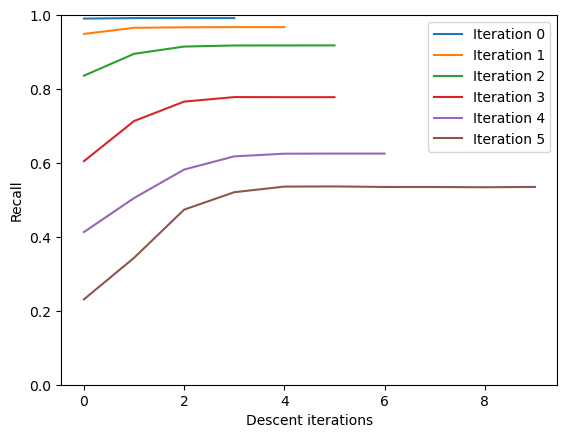

In [13]:
plt.figure()
for i, trace_item in enumerate(trace):
    plt.plot(trace_item['descent_recall'], color=f'C{i}', label=f'Iteration {i}')

plt.xlabel('Descent iterations')
plt.ylabel('Recall')
plt.legend()
plt.ylim(0, 1)
plt.show()

The descent recall includes many more edges than the ones we need for the $k$-MST. When looking only at the shortest $k$ edges between components, the recall is much higher:

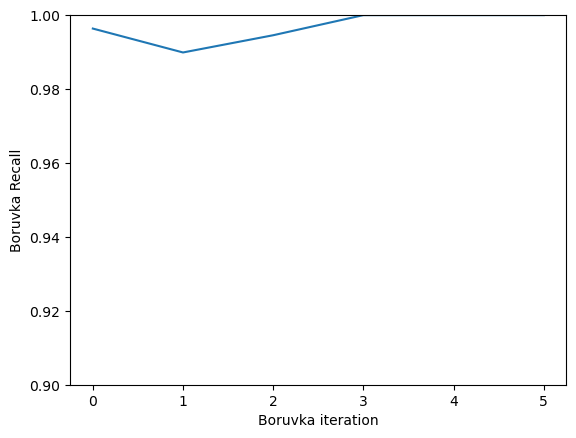

In [14]:
plt.plot([trace_item['boruvka_recall'] for trace_item in trace])
plt.ylabel('Boruvka Recall')
plt.xlabel('Boruvka iteration')
plt.ylim(0.9, 1)
plt.show()

We don't need all data points to be correct. Only the ones that have the shortest k-edges for each connected component are used in the end. So, `_KMSTDescentLogRecall` uses the ground-truth best edges per component to measure how well these edges are detected in terms of their total distance. The values should converge to 1, higher is worse.

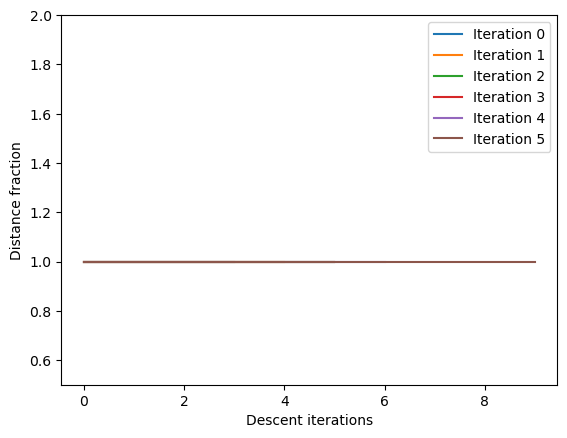

In [15]:
plt.figure()
for i, trace_item in enumerate(trace):
    plt.plot(
        trace_item["descent_distance_fraction"], color=f"C{i}", label=f"Iteration {i}"
    )

plt.xlabel("Descent iterations")
plt.ylabel("Distance fraction")
plt.legend()
plt.ylim(0.5, 2)
plt.show()

Finally, the number of changes in the descent stage indicates that later Boruvka iterations are slower to converge.

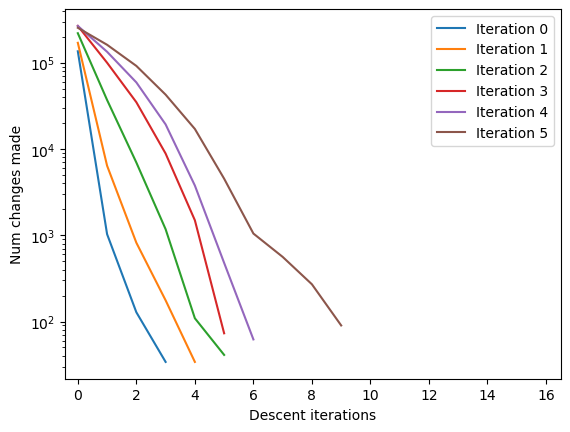

In [16]:
plt.figure()
for i, trace_item in enumerate(trace):
    plt.plot(trace_item['descent_num_changes'], color=f'C{i}', label=f'Iteration {i}')

plt.xlabel('Descent iterations')
plt.ylabel('Num changes made')
plt.yscale('log')
plt.xlim(plt.xlim()[0], 16.5)
plt.legend()
plt.show()